# StackOverflow Tags Prediction without specific packagess

# Outline
- [ 1 - Import the Data](#1)
- [ 2 - Exploring the Data](#2)
  - [ 2.1 - Bag of words](#2.1)
  - [ 2.2 - TF-IDF](#2.2)
  - [ 2.3 - CBOW](#2.3)
    - [ 2.3.1 - Data prepare](#2.3.1)
    - [ 2.3.2 - Train neuron network](#2.3.2)
    - [ 2.3.3 - PCA for plotting results](#2.3.3)
- [ 3 - Model creation and evaluation](#3)    
    

<a name="1"></a>
## 1 - Import the Data

TO DO!!!!

In this section, you will use [`Kaggle Questions csv file`](https://www.kaggle.com/code/miljan/predicting-tags-for-stackoverflow/input?select=Questions.csv) to transform the sentences into integers, so they can be fed into the model you will build later on.
[`Kaggle Labled Tags csv file`](https://www.kaggle.com/code/miljan/predicting-tags-for-stackoverflow/input?select=Tags.csv)

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse as sp_sparse
import re
from numpy import linalg as LA

In [193]:
train = pd.read_csv('/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/Questions.csv/Questions.csv',\
                    encoding = "ISO-8859-1", nrows=100000)

In [ ]:
y_data = pd.read_csv('/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/Tags.csv/Tags.csv',\
                     encoding = "ISO-8859-1")

<a name="2"></a>
## 2 - Exploring the Data and prepare data for model

In [195]:
train["Id"].nunique() == len(train) == y_data["Id"].nunique()

False

In [196]:
y_data["Id"].nunique() == len(y_data)

False

In [197]:
y_data = y_data.groupby("Id")["Tag"].apply(list).reset_index()
y_data.head()

,Id,Tag
0,80,"[flex, actionscript-3, air]"
1,90,"[svn, tortoisesvn, branch, branching-and-merging]"
2,120,"[sql, asp.net, sitemap]"
3,180,"[algorithm, language-agnostic, colors, color-s..."
4,260,"[c#, .net, scripting, compiler-construction]"


In [198]:
y_data["Id"].nunique() == len(y_data)

True

In [199]:
all_data = train.merge(y_data, how='left', left_on='Id', right_on='Id')
all_data["Tag"].isna().sum()

0

In [201]:
%matplotlib inline
import matplotlib.pyplot as plt

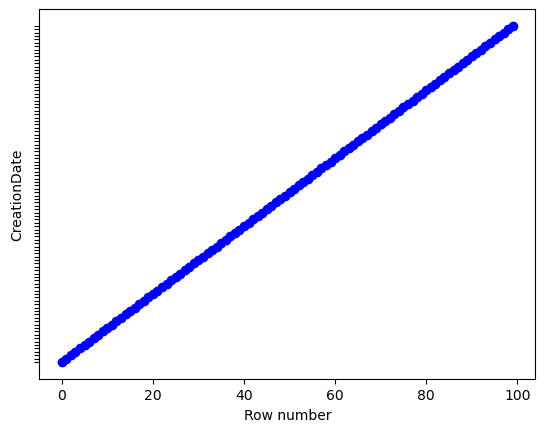

In [202]:
n=1000

fig,ax = plt.subplots(1)
ax.plot(range(len(all_data["CreationDate"][::n])), all_data["CreationDate"][::n], 'o', color='blue')
ax.set_ylabel('CreationDate')
ax.set_xlabel('Row number')

# Turn off tick labels
ax.set_yticklabels([])
plt.show()

In [203]:
def train_test_splitting(X, y, test_size, shuffle=True):
    length_data = len(X)
    test_len = int(length_data*test_size)
    train_len = length_data - test_len
    if shuffle:
        index = np.random.permutation(length_data)
        a = index[:5]
        
    else:
        index = np.arange(length_data)
    train_index = index[:train_len]
    test_index = index[train_len:]

    return X[train_index],X[test_index],y[train_index],y[test_index], a

In [458]:
np.random.seed(0)
X_train,X_test,y_train,y_test,ind = train_test_splitting(all_data["Title"], all_data["Tag"], test_size=0.3 , shuffle=True) 

In [209]:
ind_test = [ 3582, 60498, 53227, 21333,  3885]

In [210]:
assert set(ind_test) == set(ind), "Indexes don't match"

In [211]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergeiakhmadulin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [212]:
def text_prepare(text):
    
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    text = text.lower()

    text = REPLACE_BY_SPACE_RE.sub(r' ',text)
    text = BAD_SYMBOLS_RE.sub(r'',text)
    text = [w for w in text.split() if not w in STOPWORDS]
    
    return ' '.join(text)

In [213]:
X_train = [text_prepare(x) for x in X_train]
X_test = [text_prepare(x) for x in X_test]

<a name="2.1"></a>
## 2.1 - Bag of words

In [214]:
import Bagofwords as BOW

In [215]:
BagOW = BOW.BagOfWords()

In [77]:
from importlib import reload
reload(BOW)

<module 'Bagofwords' from '/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/Bagofwords.py'>

In [216]:
BagOW = BOW.BagOfWords(maximum_words = 5000)
BagOW.fit(X_train)
X_train_mybag = BagOW.transform(X_train)
X_test_mybag = BagOW.transform(X_test)
bag_of_words_dic = BagOW.get_vocab()

In [217]:
X_train_mybag

<70000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 341550 stored elements in List of Lists format>

<a name="2.2"></a>
## 2.2 - TF-IDF

 For this approuch we'll create module Tfidf that create a class and make fit, transform tramsformation

In [218]:
import Tfidf as tf

In [219]:
tfidf_obj = tf.TFIDF()
tfidf_obj.fit(X_train)

In [220]:
X_train_tfidf = tfidf_obj.transform(X_train)
X_test_tfidf = tfidf_obj.transform(X_test)
tfidf_vocab = tfidf_obj.get_vocab()

/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/Tfidf.py:43: RuntimeWarning: divide by zero encountered in divide
  norm_tfidf = tfidf.multiply(1/np.sqrt(np.sum(tfidf.power(2), axis = 1)).reshape((length_rows,1)))


In [221]:
tfidf_index_to_word = {word[0]:index for index,word in enumerate(tfidf_vocab)}

In [222]:
len(X_train)

70000

In [224]:
X_train_tfidf

<70000x28151 sparse matrix of type '<class 'numpy.float64'>'
	with 378659 stored elements in COOrdinate format>

<a name="2.3"></a>
## 2.3 - CBOW

 For this approuch we'll create two dictionaries to convert all unick words into a number and vise versa. Next we'll create two arres one with context words and another with center, that is what we are going to feed into neuron network. Train simple neuron networt with only 2 layers. As a result we'll get two matrises with trained weights the mean sum of them give us embedings of each word.

<a name="2.3.1"></a>
### 2.3.1 - Data prepare

In [225]:
def add_pad(text, num_of_padding, padding_car):
    text_with_pad = []
    for sent in text:
        sent = (padding_car + " ") * num_of_padding + sent + (" " + padding_car) * num_of_padding
        text_with_pad.append(sent)
    return text_with_pad

In [226]:
def get_dict(text): 
    idx = 0
    word2Ind = {}
    Ind2word = {}
    for sent in text:
        try:
            for word in sent.split():
                if word not in word2Ind.keys():
                    word2Ind[word] = idx
                    Ind2word[idx] = word
                    idx += 1
        except:
            for word in sent:
                if word not in word2Ind.keys():
                    word2Ind[word] = idx
                    Ind2word[idx] = word
                    idx += 1
    return word2Ind,Ind2word

In [227]:
def get_data_with_window(text, num_neighbor_words, padding = False):
    
    if padding:
        text = add_pad(text, num_neighbor_words, "PAD")
        
    word2Ind, Ind2word = get_dict(text)
    vector_lenght = len(word2Ind)
    count = 0
    for sent in text:
        length = len(sent.split()) - 2*num_neighbor_words
        if length > 0:
            count += length
    X_matrix = sp_sparse.lil_matrix((count,vector_lenght))
    y_matrix = sp_sparse.lil_matrix((count,vector_lenght))
    Y = []
    n = 0
    for row, sent in enumerate(text):
        sent_to_separete = sent.split()
        for i in range(num_neighbor_words, len(sent_to_separete) - num_neighbor_words):
            center_word = sent_to_separete[i]
            context_words = sent_to_separete[(i - num_neighbor_words):i] + sent_to_separete[(i+1):(i+num_neighbor_words+1)]
            y_matrix[n, word2Ind[center_word]] = 1
            Y.append(word2Ind[center_word])
            for con_word in context_words:
                X_matrix[n, word2Ind[con_word]] += 1
            n += 1
    X_matrix = (X_matrix/sp_sparse.lil_matrix.sum(X_matrix, axis = 1)).tolil()
    Y = np.array(Y)
    return X_matrix, Y, word2Ind, Ind2word

In [228]:
X, y, word2Ind, Ind2word  = get_data_with_window(X_train, 2, padding = True)

In [229]:
X.shape, max(Ind2word)

((384493, 28152), 28151)

<a name="2.3.2"></a>
### 2.3.2 - Train neuron network

In [230]:
import NN_for_CBOW as NN

In [231]:
res, W_1,W_2 = NN.train_network(X, y, hidden_neurons = 64, num_epoch = 4, batchsize = 100, initialization = "xavier")

done 26.0% of epoch - 0, loss: 10.079217083488908 
time for 100000 samples: 0:01:43.795003
done 52.0% of epoch - 0, loss: 8.293559011116294 
time for 100000 samples: 0:03:26.806583
done 78.0% of epoch - 0, loss: 8.116268169996228 
time for 100000 samples: 0:05:05.712090
done epoch: 0, loss: 7.947154052122614 
 weights saved
done 26.0% of epoch - 1, loss: 7.813936136084558 
time for 100000 samples: 0:01:40.157458
done 52.0% of epoch - 1, loss: 7.807762216795308 
time for 100000 samples: 0:03:17.004728
done 78.0% of epoch - 1, loss: 7.991509249881737 
time for 100000 samples: 0:04:55.216219
done epoch: 1, loss: 7.876133416517761 
 weights saved
done 26.0% of epoch - 2, loss: 7.814714439214164 
time for 100000 samples: 0:01:39.552393
done 52.0% of epoch - 2, loss: 7.802307866887494 
time for 100000 samples: 0:03:16.893595
done 78.0% of epoch - 2, loss: 7.982859796840323 
time for 100000 samples: 0:04:55.474927
done epoch: 2, loss: 7.862088946110937 
 weights saved
done 26.0% of epoch - 3,

In [76]:
res, W_1,W_2 = NN.train_network(X, y, hidden_neurons = 64, num_epoch = 4, batchsize = 100, \
                                initialization = "custom",weights_1 = W_1, weights_2 = W_2)

done 2.0% of epoch - 0, loss: 9.409370113725881 
 time for 100000 samples: 0:06:15.776176
done 3.9% of epoch - 0, loss: 8.739939438338556 
 time for 100000 samples: 0:12:22.916958
done 5.9% of epoch - 0, loss: 8.25776119276121 
 time for 100000 samples: 0:18:25.489723
done 7.9% of epoch - 0, loss: 8.23271822314867 
 time for 100000 samples: 0:24:30.342833
done 9.9% of epoch - 0, loss: 8.445524782753651 
 time for 100000 samples: 0:30:30.936172
done 11.8% of epoch - 0, loss: 8.117662160451824 
 time for 100000 samples: 0:36:36.671185
done 13.8% of epoch - 0, loss: 8.36204527775428 
 time for 100000 samples: 0:42:37.673783
done 15.8% of epoch - 0, loss: 8.242961961072115 
 time for 100000 samples: 0:48:35.373248
done 17.7% of epoch - 0, loss: 8.084340025561714 
 time for 100000 samples: 0:54:30.845691
done 19.7% of epoch - 0, loss: 8.37243577483956 
 time for 100000 samples: 1:00:26.359755
done 21.7% of epoch - 0, loss: 8.106786033534462 
 time for 100000 samples: 1:06:16.936000
done 23.

KeyboardInterrupt: 

In [36]:
W_1 = np.array(pd.read_csv("weights_1.csv", header=None))
W_2 = np.array(pd.read_csv("weights_2.csv", header=None))

In [232]:
word_embedings = (W_1 + W_2.T)/2

In [233]:
embedings_for_model = np.mean(word_embedings[1:],axis = 1)

<a name="2.3.3"></a>
### 2.3.3 - PCA for plotting results

In [234]:
def pca(data, number_components):
    if number_components<=data.shape[1]:
        cov_mat = np.cov(data.T)
        eigenvalues, eigenvectors = LA.eig(cov_mat)
        two_vectors = eigenvectors[np.argsort(eigenvalues)[:number_components]]
        return data@two_vectors.T
    else:
        raise ValueError("Number of components > data dimention")

In [236]:
data_form_pca = pca(word_embedings[1:], 2)
Ind2word_no_pad = {k:v for k,v in enumerate(list(Ind2word.values())[1:])}
word2Ind_no_pad = {k:v for v,k in Ind2word_no_pad.items()}

In [237]:
def plot_some_data(names):
    num_of_rows = list(map(word2Ind_no_pad.get, names) )
    data_to_plot = data_form_pca[num_of_rows]
    A = [i[0] for i in data_to_plot]
    B = [i[1] for i in data_to_plot]
    fig, ax = plt.subplots()
    ax.set_xlabel("Component_1")
    ax.set_ylabel("Component_2")
    
    ax.scatter(A, B)

    for i, txt in enumerate(names):
        ax.annotate(txt, (A[i], B[i]))
    plt.show()

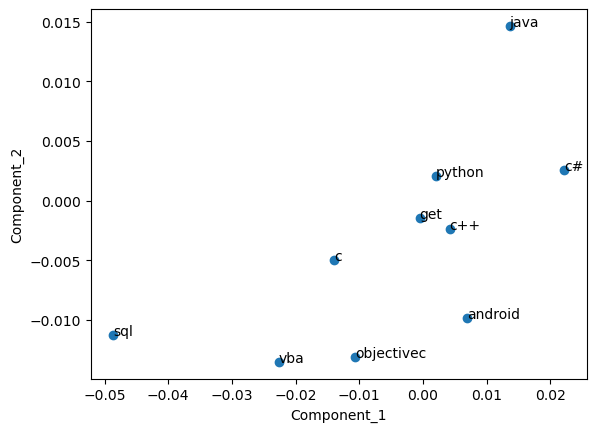

In [424]:
plot_some_data(['python','c','c++','c#','objectivec','sql','vba','get','java', 'android'])

<a name="3"></a>
## 3 - Model creation and evaluation

In [249]:
import Binarizer as binar

In [664]:
bnr = binar.Binarizer()
bnr.fit(y_train)
y_train_mat = bnr.transform(y_train)
y_test_mat = bnr.transform(y_test)

In [767]:
import Logistic_Reg as LR

In [822]:
from importlib import reload
reload(LR)

<module 'Logistic_Reg' from '/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/Logistic_Reg.py'>

In [666]:
y_test_mat.shape

(30000, 11657)

In [769]:
from importlib import reload
reload(binar)

<module 'Binarizer' from '/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/Binarizer.py'>

In [469]:
y_train_mat[:,0].shape

(70000,)

In [25]:
from sklearn.linear_model import LogisticRegression

In [28]:
clf = LogisticRegression(solver='lbfgs',max_iter=3000).fit(X_train_mybag, y_train_mat[:,0])

In [635]:
sum(clf.predict(X_train_mybag) == y_train_mat.T[0])/len(y_train_mat.T[0])

0.9435714285714286

In [650]:
from sklearn.metrics import f1_score

In [37]:
clf.score(X_test_mybag,y_test_mat.T[0])

0.9536154235572055

In [ ]:
def f1(C):
    num_classes = np.shape(C)[0]
    f1_score = np.zeros(shape=(num_classes,), dtype='float32')
    weights = np.sum(C, axis=0)/np.sum(C)

    for j in range(num_classes):
        tp = np.sum(C[j, j])
        fp = np.sum(C[j, np.concatenate((np.arange(0, j), np.arange(j+1, num_classes)))])
        fn = np.sum(C[np.concatenate((np.arange(0, j), np.arange(j+1, num_classes))), j])
#         tn = np.sum(C[np.concatenate((np.arange(0, j), np.arange(j+1, num_classes))), np.concatenate((np.arange(0, j), np.arange(j+1, num_classes)))])

        precision = tp/(tp+fp) if (tp+fp) > 0 else 0
        recall = tp/(tp+fn) if (tp+fn) > 0 else 0
        f1_score[j] = 2*precision*recall/(precision + recall)*weights[j] if (precision + recall) > 0 else 0

    f1_score = np.sum(f1_score)
    return f1_score

In [823]:
def train_model(model, x_train, y_train, x_test, resume_training = False):
    if resume_training:
        try:
            all_weights = np.load('all_weights.npy')
            all_preds = np.load('all_preds.npy')
            starting_point = all_weights.shape[0]
            if starting_point == y_train.shape[1]:
                print("All models trained")
                return all_weights, all_preds
            
        except (FileNotFoundError, IOError):
            starting_point = 0
    else:
        starting_point = 0
        
    for i in range(starting_point, y_train.shape[1]):
        model.fit(x_train, y_train[:,i, None],batchsize = 64)
        weights = np.expand_dims(model.get_param()[0], axis=0)
        predictions = model.predict_proba(x_test)
        if i == 0:
            all_weights = weights
            all_preds = predictions
        else:
            all_weights = np.concatenate((all_weights ,weights), axis=0)
            all_preds = np.concatenate((all_preds ,predictions), axis=1)
        np.save('all_weights.npy', all_weights)
        np.save('all_preds.npy', all_preds)
        print("data stored", i)

    print("All models trained")
    return predictions, all_weights

In [826]:
Log_reg = LR.MyLogisticRegression(learning_rate = 0.01, num_iterations = 50)

In [827]:
w, p = train_model(Log_reg, X_train_mybag, y_train_mat, X_test_mybag, resume_training = False)

data stored 0
data stored 1
data stored 2
data stored 3
data stored 4
data stored 5
data stored 6
data stored 7
data stored 8
data stored 9
data stored 10
data stored 11
data stored 12
data stored 13
data stored 14
data stored 15
data stored 16
data stored 17
data stored 18
data stored 19
data stored 20
data stored 21
data stored 22
data stored 23
data stored 24
data stored 25
data stored 26
data stored 27
data stored 28
data stored 29
data stored 30
data stored 31
data stored 32
data stored 33
data stored 34
data stored 35
data stored 36
data stored 37
data stored 38
data stored 39
data stored 40
data stored 41
data stored 42
data stored 43
data stored 44
data stored 45
data stored 46
data stored 47
data stored 48
data stored 49
data stored 50
data stored 51
data stored 52
data stored 53
data stored 54
data stored 55
data stored 56
data stored 57
data stored 58
data stored 59
data stored 60
data stored 61
data stored 62
data stored 63
data stored 64
data stored 65
data stored 66
data 

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/08/jl099bnd35nfjhpfdphwd9400000gn/T/ipykernel_6859/3858017738.py", line 1, in <module>
    w, p = train_model(Log_reg, X_train_mybag, y_train_mat, X_test_mybag, resume_training = False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/08/jl099bnd35nfjhpfdphwd9400000gn/T/ipykernel_6859/42736396.py", line 17, in train_model
    model.fit(x_train, y_train[:,i, None],batchsize = 64)
  File "/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/Logistic_Reg.py", line 146, in fit
    parameters, grads, cost = self.gradient_descent(w, b, X_train, Y_train, batchsize)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File

In [828]:
all_weights = np.load('all_weights.npy')

In [831]:
all_weights.shape

(131, 1, 5000)

In [643]:
np.sum(Log_reg.predict(X_test_mybag[:100]) == y_test_mat[:100,0])

100

In [701]:
Log_reg.predict(X_test_mybag[:100]).shape

(1, 100)

In [570]:
Log_reg.get_param()[0].shape

(1, 5000)

In [524]:
np.squeeze(H)

array([0.5, 0.5, 0.5])

In [481]:
x = np.array([[1,2,3], [4,5,6]])
y = np.array([[4,5,6], [1,2,3]])

In [483]:
x,y

(array([[1, 2, 3],
        [4, 5, 6]]),
 array([[4, 5, 6],
        [1, 2, 3]]))

In [482]:
np.cross(x, y, axisc=0)

array([[-3,  3],
       [ 6, -6],
       [-3,  3]])

In [455]:
y_train_mat[:128].shape

(128, 11657)

In [456]:
X_train_mybag.shape

(70000, 5000)

<a name="3.1"></a>
## 3.1 - BOW evaluation

In [31]:
X_train_mybag

<884952x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 4422607 stored elements in List of Lists format>

In [33]:
y_train_mat.T[0].shape

(884952,)

In [47]:
X_train_mybag[:128]

<128x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 636 stored elements in List of Lists format>

<a name="3.2"></a>
## 3.2 - Tfidf evaluation

In [286]:
y_train_mat.T[0].shape

(70000,)

<a name="3.3"></a>
## 3.3 - CBOW evaluation

In [83]:
X_train_tfidf.shape

(884952, 163224)

In [64]:
y_train_mat.T[0].shape

(884952,)

In [277]:
X_tr = np.array([[5,6,1,3,7,4,10,1,2,0,5,3,1,4],[1,2,0,2,3,3,9,4,4,3,6,5,3,7]]).T
Y_tr = np.array([[0,0,0,0,0,0,0,1,1,1,1,1,1,1]]).T
X_ts  = np.array([[2,3,3,3,2,4],[1,1,0,7,6,5]]).T
Y_ts  = np.array([[0,0,0,1,1,1]]).T

In [437]:
X_tr = sp_sparse.lil_matrix(np.random.randint(5, size=(2000, 2)))

In [449]:
Y_tr = np.random.randint(2,size = (2000)).T

In [450]:
Y_tr

array([1, 1, 1, ..., 0, 0, 0])

In [451]:
from importlib import reload
reload(LR)

Log_reg = LR.MyLogisticRegression(learning_rate = 1, num_iterations = 50)

In [38]:
>>> import numpy as np
>>> from sklearn.datasets import make_multilabel_classification
>>> from sklearn.multioutput import MultiOutputClassifier
>>> from sklearn.linear_model import LogisticRegression


In [39]:
>>> X, y = make_multilabel_classification(n_classes=3, random_state=0)


In [45]:
>>> clf = MultiOutputClassifier(LogisticRegression()).fit(X, y)
>>> clf.predict(X[-2:])

array([[1, 1, 1],
       [1, 0, 1]])

In [43]:
mlb_1 = MultiLabelBinarizer()
Y_1 = mlb_1.fit_transform(y_train_text_1)

((100, 20), (100, 3))

In [46]:
y[-2:]

array([[1, 1, 1],
       [1, 0, 1]])